# Turkish News Category Classification (1. Load Dataset And Preprocess)
## Import Packages

In [ ]:
from datasets import load_dataset #huggingface datasets

#Error: _csv.Error: field larger than field limit (131072)
#Solved: https://stackoverflow.com/questions/15063936/csv-error-field-larger-than-field-limit-131072
import sys
import csv
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
        
import warnings
warnings.filterwarnings('ignore')

## Load Dataset For HuggingFace

In [ ]:
ds_interpress_news_category_tr_lite_train = load_dataset("interpress_news_category_tr_lite", split="train")
ds_interpress_news_category_tr_lite_test = load_dataset("interpress_news_category_tr_lite", split="test")

Reusing dataset interpress_news_category_tr_lite (C:\Users\user\.cache\huggingface\datasets\interpress_news_category_tr_lite\270k_10class\1.0.0\49c34ed4c0c1277eaa4280dc89fa7c29ac2e6ae256d81781028d0df222346e71)
Reusing dataset interpress_news_category_tr_lite (C:\Users\user\.cache\huggingface\datasets\interpress_news_category_tr_lite\270k_10class\1.0.0\49c34ed4c0c1277eaa4280dc89fa7c29ac2e6ae256d81781028d0df222346e71)


In [ ]:
print("Number of train news: ", ds_interpress_news_category_tr_lite_train.num_rows)
print("Number of test news: ", ds_interpress_news_category_tr_lite_test.num_rows)

Number of train news:  218880
Number of test news:  54721


In [ ]:
print("Train Features: ", ds_interpress_news_category_tr_lite_train.features)
print("Test Features: ", ds_interpress_news_category_tr_lite_test.features)

Train Features:  {'content': Value(dtype='string', id=None), 'category': ClassLabel(num_classes=10, names=['kültürsanat', 'ekonomi', 'siyaset', 'eğitim', 'dünya', 'spor', 'teknoloji', 'magazin', 'sağlık', 'gündem'], names_file=None, id=None)}
Test Features:  {'content': Value(dtype='string', id=None), 'category': ClassLabel(num_classes=10, names=['kültürsanat', 'ekonomi', 'siyaset', 'eğitim', 'dünya', 'spor', 'teknoloji', 'magazin', 'sağlık', 'gündem'], names_file=None, id=None)}


### Convert to DataFrame

In [ ]:
import pandas as pd

In [ ]:
df_train = pd.DataFrame(ds_interpress_news_category_tr_lite_train)
df_test = pd.DataFrame(ds_interpress_news_category_tr_lite_test)

del ds_interpress_news_category_tr_lite_train
del ds_interpress_news_category_tr_lite_test

In [ ]:
df_train.head()

,content,category
0,Tarihten Sınıfta Kaldık Bugün tarihe damgasını...,0
1,"clş ve yatırım ortamı iyileştiriliyor, bürokra...",1
2,Animasyon meraklıları için! Yönetmen: Jennifer...,0
3,İTİ BEEF JJ SVftSL ff 44 BEEFSFISH 16)2016...,0
4,LPG Dolum - Boşaltım kursu KTSO da yapıldı Kar...,1


In [ ]:
train_categories = df_train.groupby('category')
print("Train Total Categories:", train_categories.ngroups)
print(train_categories.size())

Train Total Categories: 10
category
0    70692
1    36671
2     9645
3    10438
4     6980
5    23430
6    31652
7     5705
8    18813
9     4854
dtype: int64


In [ ]:
test_categories = df_test.groupby('category')
print("Test Total Categories:", test_categories.ngroups)
print(test_categories.size())

Test Total Categories: 10
category
0    17491
1     9086
2     2448
3     2597
4     1816
5     5975
6     7928
7     1461
8     4766
9     1153
dtype: int64


## Dataset Visualization

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
labels = ["Kültür-Sanat","Ekonomi","Siyaset","Eğitim","Dünya","Spor","Teknoloji","Magazin","Sağlık","Gündem"]

### TRAIN

<AxesSubplot:ylabel='category'>

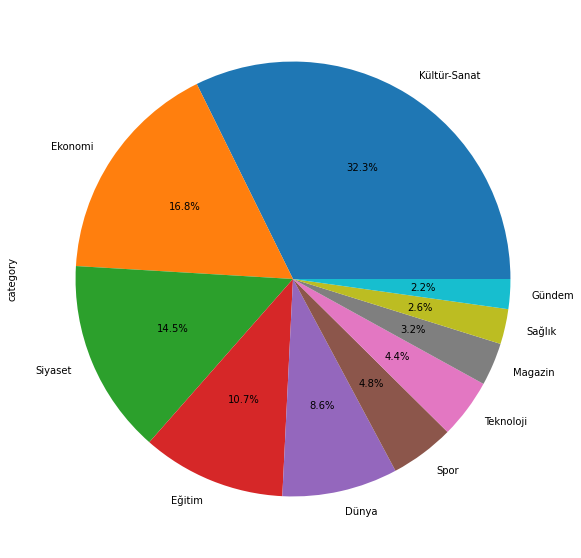

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
df_train['category'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)

### TEST

<AxesSubplot:ylabel='category'>

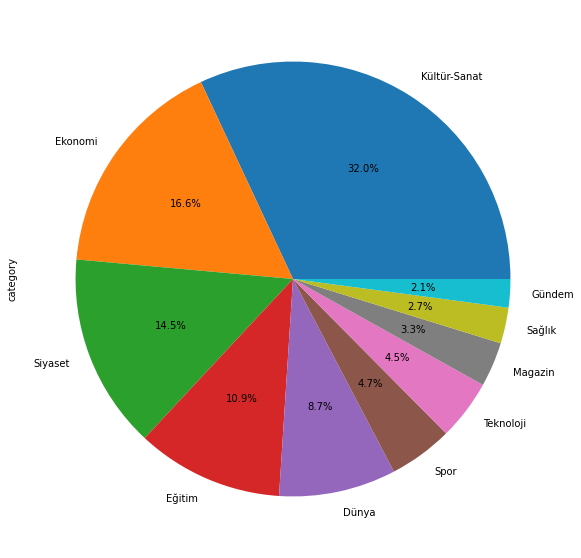

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
df_test['category'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)

## PreProcessing

In [ ]:
import re
import string
import pickle
from collections import defaultdict


PATH_ROOT = r'../' 
PATH_STOPWORDS_TR = PATH_ROOT + 'data/stopwords_tr_interpress.pkl'
PATH_BLACKLIST_TR = PATH_ROOT + 'data/tr-blacklist.pkl'

In [ ]:
#  load stopwords
def get_stopwords():
    try:
        with open(PATH_STOPWORDS_TR, 'rb') as data_file:
            return pickle.load(data_file)
    except IOError as exc:
        raise IOError("No such stopwords file! Error: " + str(exc))

#  load blacklist
def get_blacklist():
    try:
        with open(PATH_BLACKLIST_TR, 'rb') as data_file:
            return pickle.load(data_file)
    except IOError as exc:
        raise IOError("No such stopwords file! Error: " + str(exc))
        

#  cleaning stopwords
def clean_stopwords(content):
    # content: str
    content = content.split(" ")
    filtered_list = []
    stopwords = get_stopwords()
    for word in content:
        if word not in stopwords:
            filtered_list.append(word)

    text = ' '.join(filtered_list)
    return text

#  cleaning blacklist
def clean_blacklist(content):
    # content: str
    # return: str
    content = content.split(" ")
    filtered_list = []
    blacklist = get_blacklist()
    for word in content:
        if word not in blacklist:
            filtered_list.append(word)

    text = ' '.join(filtered_list)
    return text

#  cleaning URLs
def clean_url(content):
    #  content: str
    #  return: str
    reg_url = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    pattern_url = re.compile(reg_url)
    content = pattern_url.sub('',content)
    return content
    
#  cleaning e-mails
def clean_email(content):
    reg_email='\S*@\S*\s?'
    pattern_email = re.compile(reg_email)
    content = pattern_email.sub('',content)
    return content
    
#  cleaning punctuation
def clean_punctuation(content):
    #regex = re.compile('[%s]' % re.escape(string.punctuation))
    #content = regex.sub(" ", content)
    content = content.translate(content.maketrans("", "", string.punctuation))
    return content
    
#  cleaning digits
def clean_numbers(content):
    remove_digits = str.maketrans('', '', string.digits)
    text = content.translate(remove_digits)
    return text

def listToString(text):
    #  text: string
    #  return: string 
    str1 = " "  
    return (str1.join(text)) 

#  cleaning postfix
#  for example: Venezuela'nın ==> Venezuela
def clean_postfix(content):
    #  content: list
    #  return: str
    spesific_punctation = [39, 8217] # ascii codes of spesific punctations
    all_words = defaultdict(list)
    counter = 0
    for i, word in enumerate(content):
        if len(word) > 2:
            if chr(8217) in word:
                replaced_word = word.replace(chr(8217), " ")  #  clean for ’
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            elif chr(39) in word:
                replaced_word = word.replace(chr(39), " ")  # clean for '
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            else:
                all_words[i].append(word)
    all_words = sorted(all_words.items())

    text = ""
    for i in range(len(all_words)):
        text = text + " " + all_words[i][1][0]

    return text

def clean_text(content):
    #  text: string
    #  return: string
    content = content.lower()
    cleaned_email = clean_email(content)
    cleaned_email_url = clean_url(cleaned_email)
    cleaned_email_url = listToString(cleaned_email_url.split("."))
    cleaned_email_url = cleaned_email_url.split(" ")
    cleaned_email_url_postfix = clean_postfix(cleaned_email_url)
    cleaned_email_url_postfix_punctuation = clean_punctuation(cleaned_email_url_postfix)
    cleaned_email_url_postfix_punctuation_numbers = clean_numbers(cleaned_email_url_postfix_punctuation)
    cleaned_email_url_postfix_punctuation_numbers_stopwords = clean_stopwords(cleaned_email_url_postfix_punctuation_numbers)
    cleaned_email_url_postfix_punctuation_numbers_stopwords_blacklist = clean_blacklist(cleaned_email_url_postfix_punctuation_numbers_stopwords)
   
    filtered_sentence = []
    for word in cleaned_email_url_postfix_punctuation_numbers_stopwords_blacklist.split(" "):
        if len(word) > 2:
            filtered_sentence.append(word)
    
    text = ' '.join(filtered_sentence)
    return text


In [ ]:
df_train.content[1909]

'1648 TL MSI VVind Top AE2410 Beklentilerin de üstünde özellikler sunuyor. 1920 x 1080 piksel çözünürlükte ve 23,6 inç büyüklüğünde olan dokunmatik ekranıyla dikkatleri üzerine toplayan MSI Wind Top AE2410, yüksek performansı sayesinde multimedya düşkünü kullanıcıların tüm ihtiyacını karşılayabilecek güçte. İşlemci olarak Intel in Core 5 2410M modeli kullanılırken grafik kartındaysa dahili olarak sunulan Intel GMA HD3000 in yanı sıra NVIDlA nın 1 GB lık GeForce GT 540M i görev yapıyor. 23,6 inçlik ekranın kullanıldığı bilgisayarda depolama işlemlerinden 1 TB kapasitesindeki disk sorumlu. Kablolu ve kablosuz olarak birçok farklı bağlantı arabiriminin sunulduğu MSI VVind Top AE2410 da dahili olarak sunulan toplam 10 vatlık hoparlörler de oldukça kuvvetli. Firma: Penta Tel: (216) 528 00 00 Web: www.penta.com.tr işlemci: Intel Core ı5 2410M Bellek: 4 GB DDR3   1333 MHz Sabit disk: 1 TB   7200 rpm   32 MB cache Optik sürücü: DVD yazıcı Ekran: 23.6 inç 1920x1080 Grafik kartı: Intel GMA HD300

In [ ]:
labels[df_train.category[1909]]

'Teknoloji'

In [ ]:
clean_text(df_train.content[1909])

'msi vvind top beklentilerin üstünde özellikler sunuyor piksel çözünürlükte inç büyüklüğünde dokunmatik ekranıyla dikkatleri üzerine toplayan msi wind top yüksek performansı sayesinde multimedya düşkünü kullanıcıların ihtiyacını karşılayabilecek güçte i̇şlemci intel core modeli kullanılırken grafik kartındaysa dahili sunulan intel gma yanı sıra nvidla lık geforce görev inçlik ekranın kullanıldığı bilgisayarda depolama işlemlerinden kapasitesindeki disk sorumlu kablolu kablosuz bağlantı arabiriminin sunulduğu msi vvind top dahili sunulan toplam vatlık hoparlörler oldukça kuvvetli penta tel web işlemci intel core bellek ddr mhz sabit disk rpm cache optik sürücü dvd yazıcı ekran inç grafik kartı intel gma nvidia geforce gtm webcam kart okuyucu kablosuz wi̇r bluetooth genişletme sistem belleği görüntü çıkışı dsub hdmi batarya boyutlar bpyutlar i̇şletim sistemi windows home premıum ağırlık'

### Applying Text Cleanup Preprocesses for Train dataset

In [ ]:
cleaning = lambda x: clean_text(x)
df_train['clean_content'] = df_train['content'].apply(cleaning)

In [ ]:
df_train

,content,category,clean_content
0,Tarihten Sınıfta Kaldık Bugün tarihe damgasını...,0,tarihten sınıfta kaldık bugün tarihe damgasını...
1,"clş ve yatırım ortamı iyileştiriliyor, bürokra...",1,clş yatırım ortamı iyileştiriliyor bürokrasi a...
2,Animasyon meraklıları için! Yönetmen: Jennifer...,0,animasyon meraklıları yönetmen jenniferyuh ses...
3,İTİ BEEF JJ SVftSL ff 44 BEEFSFISH 16)2016...,0,i̇ti̇ beef svftsl beefsfish kirmizi eti̇n fran...
4,LPG Dolum - Boşaltım kursu KTSO da yapıldı Kar...,1,lpg dolum boşaltım kursu ktso yapıldı karaman ...
...,...,...,...
218875,Begüm-Mert Yazıcıoğiu çiftinin ikinci bebekler...,7,begümmert yazıcıoğiu çiftinin ikinci bebekleri...
218876,AKRAPOVIC FULL MOON Fiyat açıklanmadı (konsept...,6,akrapovic full moon fiyat açıklanmadı konsept ...
218877,Babil gibi bal Notlar Bugün Şenkaya ilçesine b...,0,babil bal notlar bugün şenkaya ilçesine bağlı ...
218878,ÇEVRE İSTATİSTİKLERİNİN ÖZETLERİ YAYINLANDI Tü...,1,çevre i̇stati̇sti̇kleri̇ni̇n özetleri̇ yayinla...


### Applying Text Cleanup Preprocesses for Test dataset

In [ ]:
df_test['clean_content'] = df_test['content'].apply(cleaning)

In [ ]:
df_test

,content,category,clean_content
0,50 yıldır yükselen enerji: Aygaz TÜRK HALKINI ...,1,yıldır yükselen enerji aygaz türk halkini tüpg...
1,Onur Akyıl Bir insan kadar mutsuzBir insan kad...,0,onur akyıl insan mutsuzbir insan mutsuzi onur ...
2,. yolculuk GÜNEYLİ SARIŞIN: REESE WITHERSPOON ...,0,yolculuk güneyli̇ sarişin reese witherspoon ya...
3,Doğru tercih yapan hiçbir aday açıkta kalmayac...,3,doğru tercih yapan aday açıkta kalmayacak aday...
4,De Jong için sıraya girdiler SERİE A ekipler...,5,jong sıraya girdiler seri̇e ekiplerinden lan b...
...,...,...,...
54716,"SAMBACI JAJA ALKOL ENGELİNE TAKILDI .m, TRABZO...",5,sambaci jaja alkol engeli̇ne takildi trabzonsp...
54717,"Gıda Tarım ve Hayvancılık Bakanı Faruk Çelik, ...",1,gıda tarım hayvancılık bakanı faruk çelik ekme...
54718,PANORAMA Uftk. Uluslararası Whitley Doğa Korum...,0,panorama uftk uluslararası whitley doğa koruma...
54719,Patates tüketiminin artırılması hedefleniyor A...,1,patates tüketiminin artırılması hedefleniyor a...


### Saving datasets obtained from preprocessing.

In [ ]:
df_train.to_pickle(PATH_ROOT + 'datasets/interpress_news_category_tr_lite_train_cleaned.pkl')
df_test.to_pickle(PATH_ROOT + 'datasets/interpress_news_category_tr_lite_test_cleaned.pkl')